In [1]:
# Calling libraries:
from __future__ import division
%matplotlib inline
import numpy as np, time, matplotlib.pyplot as plt, math, pandas, numpy.random as npr, multiprocessing as mp, copy
from pylab import plot, show, legend
from time import time
from scipy.stats import *
from tqdm import trange
from ecology_functions import *

In [2]:
T = 20
I = 4  # number of locations
J = 2  # number of species
K = 2   # number of latent factors

In [3]:
lmbda = npr.randn(J,K)
alpha = npr.randn(J)
c = 0
phi = 0.5
logsigmasq = 0
x_0 = npr.randn(I,K)

theta = [alpha, lmbda, c, phi, logsigmasq]
Y, X = simulate_data(x_0, T, J, theta)

In [10]:
n_particles = 100
rep = 200
logNC_local = np.zeros((I,rep))
for i in range(I) :
    def f(n_particles) :
        return bootstrap_PF_grad(np.reshape(Y[:,i],[T,1,J]), np.reshape(x_0[i],[1,K]), 
                                       n_particles, theta, calc_grad=False)[0]
    pool = mp.Pool(10)
    result = pool.map(f, [n_particles for n_particles in [n_particles]*rep])
    pool.close()
    for r in range(rep) :
        logNC_local[i,r] = result[r]

In [11]:
logNC = np.zeros(rep)
def f(n_particles) :
    return bootstrap_PF_grad(Y, x_0, n_particles, theta, calc_grad=False)[0]
pool = mp.Pool(10)
result = pool.map(f, [n_particles for n_particles in [n_particles]*rep])
pool.close()
for r in range(rep) :
    logNC[r] = result[r]

In [12]:
np.var(logNC), np.var(np.sum(logNC_local,0))

(2.843709479709919, 0.7925575345091573)

In [13]:
np.mean(logNC), np.mean(np.sum(logNC_local,0))

(-105.73102625039806, -104.99924154442327)

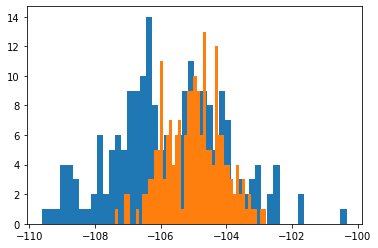

In [14]:
plt.hist(logNC, bins=50)
plt.hist(np.sum(logNC_local,0), bins=50);

In [9]:
np.var(logNC_local,1)

array([0.30863459, 0.29019447, 0.33668936, 0.33693306, 0.35773928,
       0.31041855, 0.2754959 , 0.31932739, 0.33470466, 0.3033458 ])

In [10]:
theta_grad_local = [np.zeros((rep,J)), np.zeros((rep,J,K)), np.zeros(rep), np.zeros(rep), np.zeros(rep)]
for i in range(I) :
    def f(n_particles) :
        return bootstrap_PF_grad(np.reshape(Y[:,i],[T,1,J]), np.reshape(x_0[i],[1,K]), 
                                       n_particles, theta, calc_grad=True)[1]
    pool = mp.Pool(10)
    result = pool.map(f, [n_particles for n_particles in [n_particles]*rep])
    pool.close()
    for idx in range(5) :
        for r in range(rep) :
            theta_grad_local[idx][r] += result[r][idx]

In [11]:
theta_grad = [np.zeros((rep,J)), np.zeros((rep,J,K)), np.zeros(rep), np.zeros(rep), np.zeros(rep)]
def f(n_particles) :
    return bootstrap_PF_grad(Y, x_0, n_particles, theta, calc_grad=True)[1]
pool = mp.Pool(10)
result = pool.map(f, [n_particles for n_particles in [n_particles]*rep])
pool.close()
for idx in range(5) :
    for r in range(rep) :
        theta_grad[idx][r] = result[r][idx]

In [12]:
for idx in range(5) :
    print(np.mean(theta_grad_local[idx],0))

[13.2336261  -4.73572985  2.78246598 -2.23920043  2.45117124]
[[  2.80005192  -2.02903278  -1.15292634]
 [ -1.29656102 -10.12617224   6.96417555]
 [ 10.2902271   -9.57026598   8.95021285]
 [  1.23220383  -0.54634374  -2.50808323]
 [ -9.86053014  -8.95032401   3.59956035]]
-29.01812440490722
-2967.1346346102027
1495.848322406967


In [13]:
for idx in range(5) :
    print(np.mean(theta_grad[idx],0))

[14.30114268 -6.37430522  0.19684249  1.87644702 17.08393283]
[[ 18.44131088 -86.53129833 -20.44114369]
 [-37.50479833 -10.8488828    6.595974  ]
 [ 23.4228644   21.78408209  13.35492283]
 [ 45.36134868  23.9236836  -70.85105596]
 [ 12.46382291 -34.46744852  14.49133063]]
-33.970603929431086
-2504.9468771007237
1368.407472110399


In [14]:
for idx in range(5) :
    print(np.var(theta_grad_local[idx],0))

[13.66493816  8.57958998  4.92630276 14.80406904  7.59878907]
[[23.87339918 23.56435949 19.45662444]
 [ 6.22972147 17.12877019 11.72965785]
 [17.85788382 29.27191482 19.01322608]
 [20.89368973 25.93099359 11.48647298]
 [10.83112297 21.28078162 13.89048957]]
107.64518433451693
2097.1585780729606
256.5283736660069


In [15]:
for idx in range(5) :
    print(np.var(theta_grad[idx],0))

[122.67599984  89.48817761  47.3462233  131.10799826  70.4676401 ]
[[182.96008205 218.92562989 161.93118394]
 [ 70.9617351  144.81923202 113.20579366]
 [132.37111457 194.82700804 123.03714576]
 [186.86152187 224.37736212 104.36019461]
 [103.8072818  183.44634146 113.45118988]]
900.9833586119335
9616.143953779772
1280.0231356361187


In [15]:
def f(i) :
    return bootstrap_PF_grad(np.reshape(Y[:,i],[T,1,J]), np.reshape(x_0[i],[1,K]), 
                                   n_particles, theta, calc_grad=False)[0]
def bootstrap_pf_par(Y, x_0, n_particles, theta) :
    pool = mp.Pool(10)
    result = pool.map(f, [i for i in range(I)])
    pool.close()
    return np.sum(result)

In [16]:
bootstrap_pf_par(Y, x_0, n_particles, theta)

-105.43853564200361

In [17]:
def pMCMC_RW_apprx(x_0, Y, theta_0, n_particles, n_mcmc, scale, update, power=1) :
    
    npr.seed()
    scipy.random.seed()
    
    alpha_chain, lmbda_chain, c_chain, phi_chain, logsigmasq_chain, lls, theta_mu, theta_m2 = initialise(theta_0, n_mcmc)
    theta_chain = [alpha_chain, lmbda_chain, c_chain, phi_chain, logsigmasq_chain]
    
    theta_curr = [alpha_chain[0], lmbda_chain[0], c_chain[0], phi_chain[0], logsigmasq_chain[0]]    
    lls[0] = bootstrap_pf_par(Y, x_0, n_particles, theta_curr)
    accepted = 0
    last_jump = 0
    
    for n in trange(n_mcmc) :
        theta_prop = propose_RW(theta_curr, scale, update)
        ll_prop = bootstrap_pf_par(Y, x_0, n_particles, theta_prop)
        log_prior_curr, log_prior_prop = log_prior(theta_curr), log_prior(theta_prop) 
        log_accept_prob = power*(ll_prop-lls[n]) + (log_prior_prop-log_prior_curr)
        
        if np.log(npr.rand()) < log_accept_prob :
            lls[n+1] = ll_prop
            theta_curr = np.copy(theta_prop)
            accepted += 1
            last_jump = n
        else :
            lls[n+1] = lls[n]
            if n - last_jump > 50 :
                lls[n+1] = block_PF(Y, x_0, n_particles, theta_curr, calc_grad=False)[0]
        theta_chain = push(theta_chain, theta_curr, n+1)

    print(100*accepted/n_mcmc, "% acceptance rate")
    return theta_chain, scale

In [28]:
n_particles = 100
n_mcmc = 5*10**3
scale = [5e-1*np.eye(J), 5e-1*np.eye(J*K), 0, 0, 0]
update = [1, 1, 0, 0, 0]
theta_0 = theta

In [29]:
theta_chain_pow1, scale = pMCMC_RW_apprx(x_0, Y, theta_0, n_particles, n_mcmc, scale, update, power=1)

/home/postdoc/dsen/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:792: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, order=order, subok=subok, copy=True)
100%|██████████| 5000/5000 [03:17<00:00, 25.28it/s]

31.14 % acceptance rate


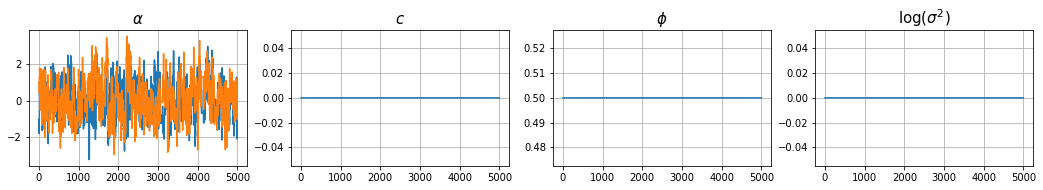

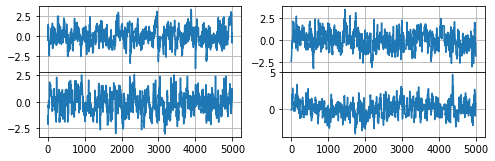

In [30]:
plot_theta_trajectory(theta_chain_pow1)

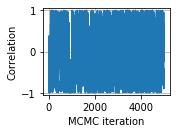

In [31]:
corrs_lmbda_pow1 = get_corrs(theta_chain_pow1[1])
plt.rcParams['figure.figsize'] = (5, 3.5)
for j1 in np.arange(1,J) :
    for j2 in range(j1) :
        plt.subplot(J,J,j1*J+j2+1)
        plt.plot(corrs_lmbda_pow1[:,j1,j2])
#         plt.title("j1 =", j1+1, "j2 =", j2+1)
        plt.grid(True)
        if j1 == J-1 : plt.xlabel("MCMC iteration")
        if j2 == 0 : plt.ylabel("Correlation")
        plt.ylim(-1.05,1.05)

In [50]:
scale = [3e-1*np.eye(J), 3e-1*np.eye(J*K), 0, 0, 0]
update = [1, 1, 0, 0, 0]
theta_0 = theta

In [54]:
power = 5
n_mcmc = 2*10**4
theta_chain_pow5, scale = pMCMC_RW_apprx(x_0, Y, theta_0, power*n_particles, n_mcmc, scale, update, power)

/home/postdoc/dsen/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:792: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, order=order, subok=subok, copy=True)
100%|██████████| 20000/20000 [13:20<00:00, 24.98it/s]

7.425 % acceptance rate


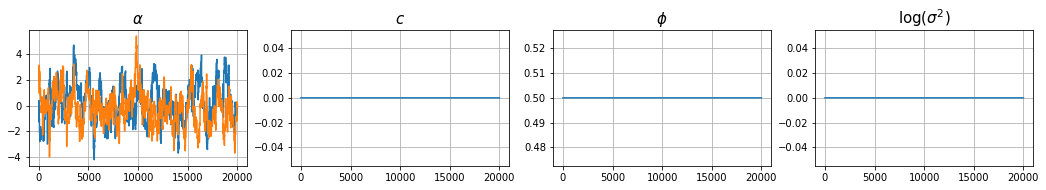

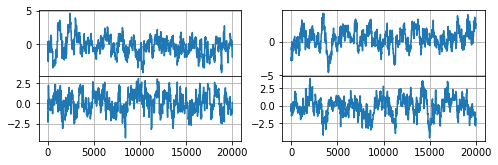

In [55]:
plot_theta_trajectory(theta_chain_pow5)

In [61]:
np.var(theta_chain_pow5[0],0), np.var(theta_chain_pow1[0],0)

(array([2.28239738, 1.73024185]), array([0.94617441, 1.12911678]))

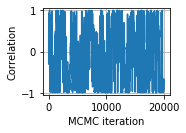

In [56]:
corrs_lmbda_pow5 = get_corrs(theta_chain_pow5[1])
plt.rcParams['figure.figsize'] = (5, 3.5)
for j1 in np.arange(1,J) :
    for j2 in range(j1) :
        plt.subplot(J,J,j1*J+j2+1)
        plt.plot(corrs_lmbda_pow5[:,j1,j2])
#         plt.title("j1 =", j1+1, "j2 =", j2+1)
        plt.grid(True)
        if j1 == J-1 : plt.xlabel("MCMC iteration")
        if j2 == 0 : plt.ylabel("Correlation")
        plt.ylim(-1.05,1.05)

In [57]:
np.mean(corrs_lmbda_pow5), np.mean(corrs_lmbda_pow1)

(0.4429563392366231, 0.5126548251303517)

In [58]:
np.var(corrs_lmbda_pow5), np.var(corrs_lmbda_pow1)

(0.5512965647402622, 0.49444548076723516)